## MSTICPy and Notebooks in InfoSec

---

<h1 style="border: solid; padding:5pt; color:black; background-color:#909090">Session 5 - Enrichment and Context</h1>

---

## What this session covers:

- Pivot functions
  - Basics
  - Data queries
  - Chained pivot functions
- Beyond pivots - Threat Intelligence providers
- Azure APIs - Sentinel


## Prerequisites
- Python >= 3.8 Environment
- Jupyter installed
- MSTICPy installed
- Run az login

## Recommended
- VS Code


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Notebook Setup</a>

---

In [1]:
%env MSTICPYCONFIG=./msticpyconfig.yaml
import msticpy as mp
mp.init_notebook()

env: MSTICPYCONFIG=./msticpyconfig.yaml


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">What is enrichment?</a>

---

### Answering questions about an entity to give you insight into intent and activity


## Answering questions about an entity to give you insight into intent and activity

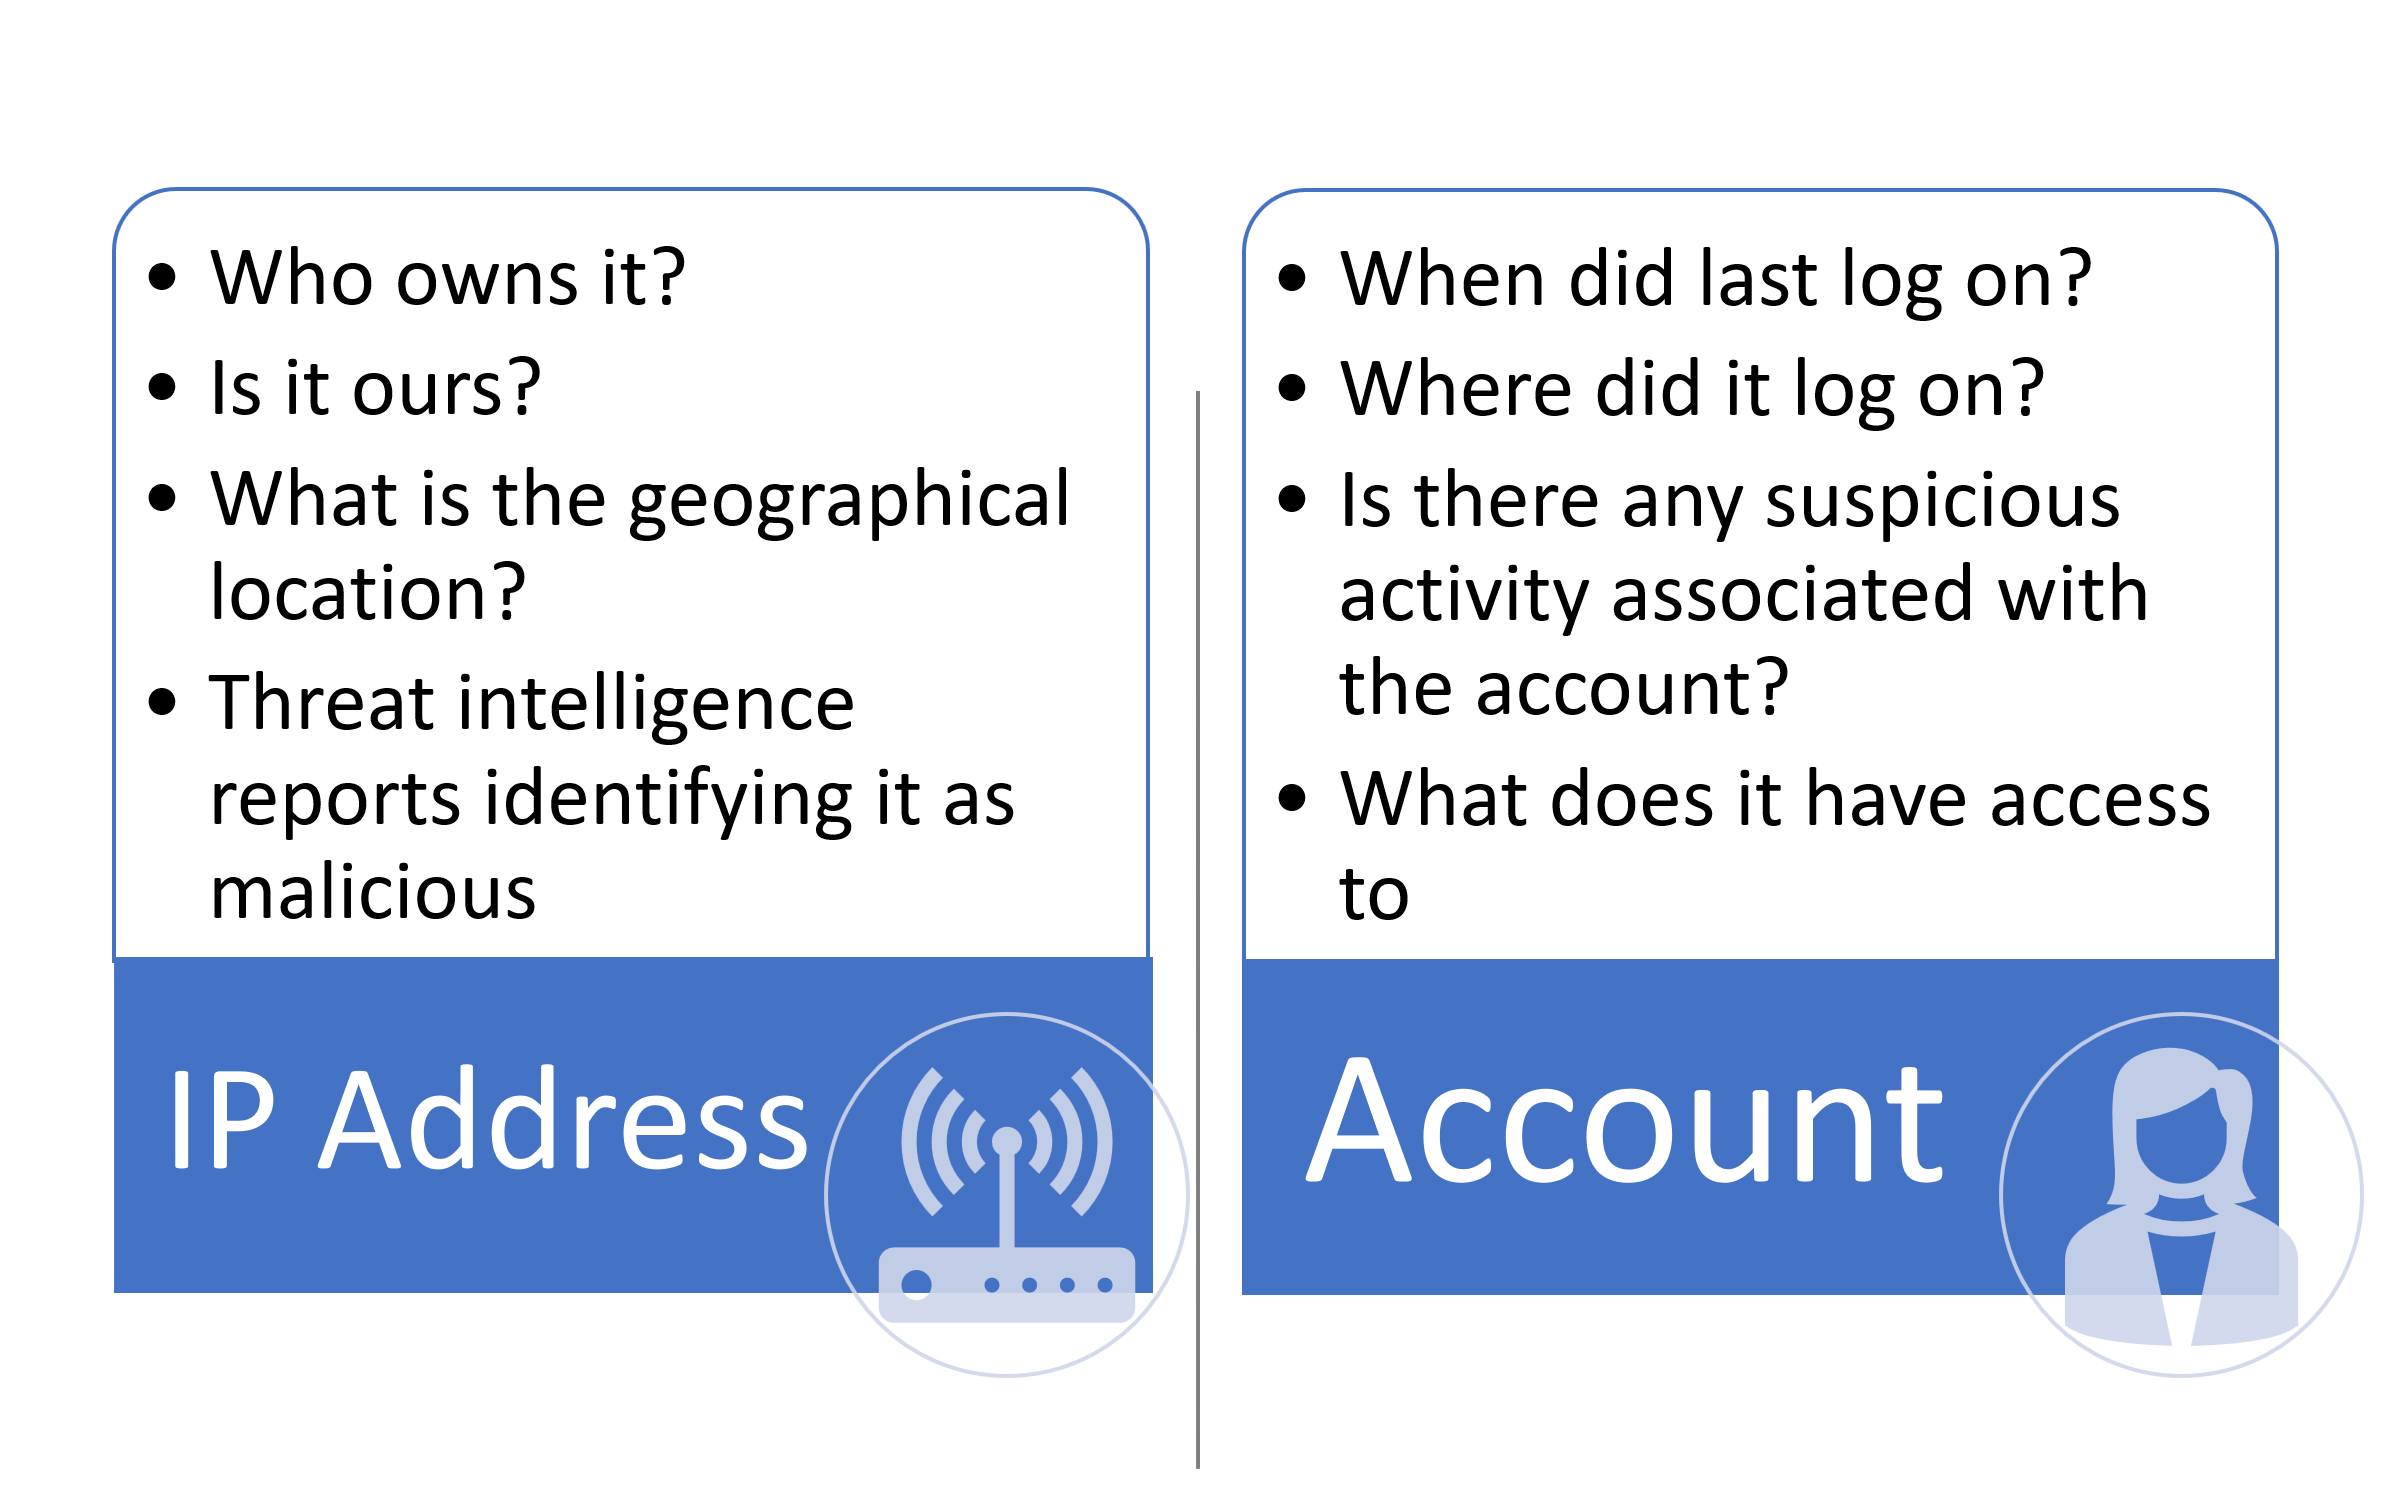

In [2]:
from IPython.display import Image, Markdown
from time import sleep

display(Markdown("## Answering questions about an entity to give you insight into intent and activity"))
sleep(2)
display(Image("./media/enrichment_1.png", width="70%"))

In [3]:
display(Markdown("## ...and for a whole range of entities"))

for entity in dir(mp.entities):
    cls = getattr(mp.entities, entity)
    if isinstance(cls, type) and issubclass(cls, mp.entities.Entity):
        print(entity, end="  ")
        sleep(0.1)

## ...and for a whole range of entities

Account  Alert  AzureResource  CloudApplication  CloudLogonSession  Dns  Entity  File  FileHash  GeoLocation  Host  HostLogonSession  Incident  IoTDevice  IpAddress  MailCluster  MailMessage  Mailbox  Malware  NetworkConnection  Process  RegistryKey  RegistryValue  SecurityGroup  SubmissionMail  Threatintelligence  UnknownEntity  Url  

---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">MSTICPy Pivots</a>

---

### **Pivots** or **Pivot Functions** are contextual functions attached to **Entities**
#### [Pivot Documentation](https://msticpy.readthedocs.io/en/latest/data_analysis/PivotFunctions.html)

In [4]:
IpAddress.pivots()

['VT.vt_communicating_files',
 'VT.vt_historical_ssl_certificates',
 'VT.vt_historical_whois',
 'VT.vt_referrer_files',
 'VT.vt_resolutions',
 'VT.vt_subdomains',
 'geoloc',
 'ip_type',
 'ti.lookup_ip',
 'tilookup_ip',
 'util.geoloc',
 'util.geoloc_ips',
 'util.ip_rev_resolve',
 'util.ip_type',
 'util.whois',
 'util.whois_asn',
 'whois',
 'whois_asn']

In [5]:
mp.Pivot().browse()

## Example utility functions

- Entities are auto-imported by `mp.init_notebook()`
- Support auto/tabbed completion

In [ ]:
IpAddress

In [5]:
IpAddress.whois("54.69.246.204")

,ip_column,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,54.69.246.204,16509,54.69.246.204,54.68.0.0/15,US,arin,2014-06-20,"AMAZON-02, US","[{'cidr': '54.64.0.0/11', 'handle': 'NET-54-64-0-0-1', 'name': 'AMAZON-2011L', 'startAddress': '...","{'asn': '16509', 'query': '54.69.246.204', 'asn_cidr': '54.68.0.0/15', 'asn_country_code': 'US',...","AMAZON-02, US"


In [6]:
Dns.util.dns_components("www.microsoft.com")

,subdomain,domain,suffix,src_row_index
0,www,www.microsoft.com,com,0


In [8]:
Url.util.url_components("https://ms.web.azuresynapse.net/en/authoring/orchestrate/pipeline/Notebook%20test%20simple?workspace=%2Fsubscriptions%2F40dcc8bf-0478-4f3b-b275-ed0a94f2c013%2FresourceGroups%2FASIHuntOMSWorkspaceRG%2Fproviders%2FMicrosoft.Synapse%2Fworkspaces%2Fianhelle-synapse1&livyId=18&sparkPoolName=ianhellespark1&snapshotId=d941f342-272e-4898-9eee-19aa90f05f44")

,scheme,auth,host,port,path,query,fragment,url,src_row_index
0,https,None,ms.web.azuresynapse.net,None,/en/authoring/orchestrate/pipeline/Notebook%20test%20simple,workspace=%2Fsubscriptions%2F40dcc8bf-0478-4f3b-b275-ed0a94f2c013%2FresourceGroups%2FASIHuntOMSW...,None,https://ms.web.azuresynapse.net/en/authoring/orchestrate/pipeline/Notebook%20test%20simple?works...,0


In [7]:
Dns.util.dns_resolve("www.microsoft.com")

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,rrset,expiration
0,www.microsoft.com.,A,IN,id 25747\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,192.168.0.1,53,e13678.dscb.akamaiedge.net.,104.97.41.163,2022-10-15 23:05:05.962807


## Threat Intel providers

In [11]:
IpAddress.tilookup_ip("54.69.246.204") #, providers=["VirusTotal"])

Observables processed: 100%|██████████| 1/1 [00:00<00:00, 329.02obs/s]


,Ioc,IocType,SanitizedValue,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,54.69.246.204,ipv4,54.69.246.204,None,VirusTotal,True,information,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'positives': 0, 'detected_urls': []...","{'asn': 16509, 'undetected_urls': [['http://54.69.246.204:53802/', 'd72f9d5c7c34f834ffcc767c7c31...",https://www.virustotal.com/vtapi/v2/ip-address/report,0


## Support lists as inputs

### Actually support iterables: list, tuple, set, generator, pandas series.

In [11]:
IpAddress.geoloc(["54.69.246.204", "104.73.1.162"])

,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,US,United States,Oregon,Boardman,-119.7257,45.8234,2022-10-13 21:17:49.749372,geolocation,54.69.246.204
1,US,United States,Washington,Seattle,-122.3414,47.6034,2022-10-13 21:17:49.751368,geolocation,104.73.1.162


## DataFrames as inputs

In [12]:
qry_local = mp.QueryProvider("LocalData")
ip_flow_df = qry_local.Network.list_azure_network_flows_by_host()
ip_flow_df.head(2)

,TenantId,TimeGenerated,FlowStartTime,FlowEndTime,FlowIntervalEndTime,FlowType,ResourceGroup,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows,DeniedInFlows,DeniedOutFlows,RemoteRegion,VMRegion,AllExtIPs,TotalAllowedFlows
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 13:23:59.512,2019-02-14 12:21:58,2019-02-14 12:21:58,2019-02-14 13:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,[13.67.143.117],,,T,https,443.0,O,1.0,0.0,0.0,0.0,centralus,eastus,13.67.143.117,1.0
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 13:23:59.512,2019-02-14 12:29:02,2019-02-14 12:29:02,2019-02-14 13:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,[40.77.232.95],,,T,https,443.0,O,1.0,0.0,0.0,0.0,westcentralus,eastus,40.77.232.95,1.0


In [7]:
IpAddress.whois(ip_flow_df.head(5), column="AllExtIPs")

,TenantId,TimeGenerated,FlowStartTime,FlowEndTime,FlowIntervalEndTime,FlowType,ResourceGroup,VMName,VMIPAddress,PublicIPs,SrcIP,DestIP,L4Protocol,L7Protocol,DestPort,FlowDirection,AllowedOutFlows,AllowedInFlows,DeniedInFlows,DeniedOutFlows,RemoteRegion,VMRegion,AllExtIPs,TotalAllowedFlows,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 13:23:59.512,2019-02-14 12:21:58,2019-02-14 12:21:58,2019-02-14 13:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,[13.67.143.117],,,T,https,443.0,O,1.0,0.0,0.0,0.0,centralus,eastus,13.67.143.117,1.0,8075,13.67.143.117,13.64.0.0/11,US,arin,2015-03-26,"MICROSOFT-CORP-MSN-AS-BLOCK, US","[{'cidr': '13.64.0.0/11', 'handle': 'NET-13-64-0-0-1', 'name': 'MSFT', 'startAddress': '13.64.0....","{'asn': '8075', 'query': '13.67.143.117', 'asn_cidr': '13.64.0.0/11', 'asn_country_code': 'US', ...","MICROSOFT-CORP-MSN-AS-BLOCK, US"
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 13:23:59.512,2019-02-14 12:29:02,2019-02-14 12:29:02,2019-02-14 13:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,[40.77.232.95],,,T,https,443.0,O,1.0,0.0,0.0,0.0,westcentralus,eastus,40.77.232.95,1.0,8075,40.77.232.95,40.76.0.0/14,US,arin,2015-02-23,"MICROSOFT-CORP-MSN-AS-BLOCK, US","[{'cidr': '40.74.0.0/15', 'handle': 'NET-40-74-0-0-1', 'name': 'MSFT', 'startAddress': '40.74.0....","{'asn': '8075', 'query': '40.77.232.95', 'asn_cidr': '40.76.0.0/14', 'asn_country_code': 'US', '...","MICROSOFT-CORP-MSN-AS-BLOCK, US"
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 03:26:06.765,2019-02-14 02:08:46,2019-02-14 02:48:45,2019-02-14 03:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,"[13.65.107.32, 40.124.45.19]",,,T,https,443.0,O,4.0,0.0,0.0,0.0,southcentralus,eastus,13.65.107.32,4.0,8075,13.65.107.32,13.64.0.0/11,US,arin,2015-03-26,"MICROSOFT-CORP-MSN-AS-BLOCK, US","[{'cidr': '13.64.0.0/11', 'handle': 'NET-13-64-0-0-1', 'name': 'MSFT', 'startAddress': '13.64.0....","{'asn': '8075', 'query': '13.65.107.32', 'asn_cidr': '13.64.0.0/11', 'asn_country_code': 'US', '...","MICROSOFT-CORP-MSN-AS-BLOCK, US"
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 03:26:06.765,2019-02-14 02:08:46,2019-02-14 02:48:45,2019-02-14 03:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,"[13.65.107.32, 40.124.45.19]",,,T,https,443.0,O,4.0,0.0,0.0,0.0,southcentralus,eastus,40.124.45.19,4.0,8075,40.124.45.19,40.124.0.0/16,US,arin,2015-02-23,"MICROSOFT-CORP-MSN-AS-BLOCK, US","[{'cidr': '40.74.0.0/15', 'handle': 'NET-40-74-0-0-1', 'name': 'MSFT', 'startAddress': '40.74.0....","{'asn': '8075', 'query': '40.124.45.19', 'asn_cidr': '40.124.0.0/16', 'asn_country_code': 'US', ...","MICROSOFT-CORP-MSN-AS-BLOCK, US"
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,2019-02-14 03:26:06.828,2019-02-14 02:30:56,2019-02-14 02:30:56,2019-02-14 03:00:00,AzurePublic,asihuntomsworkspacerg,msticalertswin1,10.0.3.5,[20.38.98.100],,,T,https,443.0,O,1.0,0.0,0.0,0.0,eastus,eastus,20.38.98.100,1.0,8075,20.38.98.100,20.36.0.0/14,US,arin,2017-10-18,"MICROSOFT-CORP-MSN-AS-BLOCK, US","[{'cidr': '20.33.0.0/16', 'handle': 'NET-20-33-0-0-1', 'name': 'MSFT', 'startAddress': '20.33.0....","{'asn': '8075', 'query': '20.38.98.100', 'asn_cidr': '20.36.0.0/14', 'asn_country_code': 'US', '...","MICROSOFT-CORP-MSN-AS-BLOCK, US"


## <a style="border: solid; padding:5pt; color:black; background-color:#309030">Task 1 - Find WhoIs and GeoLocation info for Domain/Hosts</a>

1. Use pivot function to resolve domains (`Dns`) to IP Addresses
2. Find the Geo Location and WhoIs info for these addresses.

<details>
<summary>Hints...</summary>
<ul>
<li>Use the Dns class to resolve the domains to IP Addresses.</li>
<li>The IP address is returned in the 'rrest' column</li>
<li>Use the IpAddress "whois" and "geoip" functions to find the details</li>
</ul>
</details>

In [9]:
domains = [
    "www.microsoft.com",
    "python.org",
    "kexp.org"
]

dns_df = Dns.util.dns_resolve(domains)

In [11]:
IpAddress.whois(dns_df, column="rrset")
IpAddress.geoloc(dns_df, column="rrset")

,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,US,United States,Washington,Seattle,-122.3414,47.6034,2022-10-15 20:20:13.475652,geolocation,184.26.82.115
1,US,United States,New Jersey,Clifton,-74.1403,40.8364,2022-10-15 20:20:13.478652,geolocation,138.197.63.241
2,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:20:13.480894,geolocation,104.22.15.150
3,US,United States,NaN,NaN,-97.8220,37.7510,2022-10-15 20:20:13.482895,geolocation,172.67.15.81
4,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:20:13.482895,geolocation,104.22.14.150


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Pivot functions can be queries.</a>

---

## Loading data providers adds new pivot functions dynamically

### Previous Host pivots
```python
['VT.vt_communicating_files',
 'VT.vt_historical_ssl_certificates',
 'VT.vt_historical_whois',
 'VT.vt_referrer_files',
 'VT.vt_resolutions',
 'VT.vt_subdomains',
 'geoloc',
 'ip_type',
 'ti.lookup_ip',
 'tilookup_ip',
 'util.geoloc',
 'util.geoloc_ips',
 'util.ip_rev_resolve',
 'util.ip_type',
 'util.whois',
 'util.whois_asn',
 'whois',
 'whois_asn']
```

### Create a Data provider

In [13]:
qry_prov = mp.QueryProvider("MSSentinel")
qry_prov.connect(workspace="Default")

Please wait. Loading Kqlmagic extension...done
Connecting... 

connected


In [14]:
IpAddress.pivots()

['MSSentinel.DeviceNetworkEvents_ip_connections',
 'MSSentinel.VMComputer_vmcomputer',
 'MSSentinel.aad_signins',
 'MSSentinel.az_nsg_interface',
 'MSSentinel.az_nsg_net_flows',
 'MSSentinel.az_stor_storage_ops',
 'MSSentinel.azure_activity',
 'MSSentinel.dns_queries',
 'MSSentinel.dns_queries_from_ip',
 'MSSentinel.heartbeat',
 'MSSentinel.heartbeat_for_ip_depr',
 'MSSentinel.o365_activity',
 'MSSentinel.sec_list_alerts_for_ip',
 'MSSentinel.sent_bookmarks',
 'MSSentinel.syslog_logon_failures',
 'MSSentinel.syslog_logons',
 'MSSentinel.ti_list_indicators_by_ip',
 'MSSentinel.wevt_logon_attempts',
 'VT.vt_communicating_files',
 'VT.vt_historical_ssl_certificates',
 'VT.vt_historical_whois',
 'VT.vt_referrer_files',
 'VT.vt_resolutions',
 'VT.vt_subdomains',
 'geoloc',
 'ip_type',
 'ti.lookup_ip',
 'tilookup_ip',
 'util.geoloc',
 'util.geoloc_ips',
 'util.ip_rev_resolve',
 'util.ip_type',
 'util.whois',
 'util.whois_asn',
 'whois',
 'whois_asn']

## Adding queries is a very easy way of adding custom pivot functions

### You can also add arbitrary functions (see appendix)

If you create a query with one of these parameters it will be automatically added
to the mapped entity as a pivot function.

| Query Parameter  | Entity                               |
|------------------|--------------------------------------|
| account_name     | Account                              |
| user             | Account                              |
| host_name        | Host                                 |
| process_name     | Process                              |
| source_ip_list   | IpAddress                            |
| ip_address_list  | IpAddress                            |
| ip_address       | IpAddress                            |
| logon_session_id | Process, , HostLogonSession, Account |
| process_id       | Process                              |
| commandline      | Process                              |
| user             | Account                              |
| url              | Url                                  |
| file_hash        | File                                 |
| domain           | Dns                                  |
| resource_id      | AzureResource                        |


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Chaining Pivot functions</a>

---

### Because Pivot functions use DataFrames as output and input you can use them in a pipeline

### Use the Pandas `mp_pivot.run()` function to add steps to the pipeline


```python
# Take 3 functions from previous task
Dns.util.dns_resolve(domains)
IpAddress.whois(dns_df, column="rrset")
IpAddress.geoloc(dns_df, column="rrset")
```

In [12]:
# Use .mp_pivot.run to pipe output of first to input of second function
(
    Dns.util.dns_resolve(domains)
    .mp_pivot.run(IpAddress.whois, column="rrset")
)

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,rrset,expiration,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,www.microsoft.com.,A,IN,id 53072\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,192.168.0.1,53,e13678.dscb.akamaiedge.net.,184.26.82.115,2022-10-15 20:21:43.481142,16625,184.26.82.115,184.26.80.0/22,US,arin,2010-10-11,"AKAMAI-AS, US","[{'cidr': '184.24.0.0/13', 'handle': 'NET-184-24-0-0-1', 'name': 'AKAMAI', 'startAddress': '184....","{'asn': '16625', 'query': '184.26.82.115', 'asn_cidr': '184.26.80.0/22', 'asn_country_code': 'US...","AKAMAI-AS, US"
1,python.org.,A,IN,id 10466\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\npython.org. IN A\n;ANSWER\npyt...,192.168.0.1,53,python.org.,138.197.63.241,2022-10-16 20:21:34.491672,14061,138.197.63.241,138.197.60.0/22,US,arin,2016-01-26,"DIGITALOCEAN-ASN, US","[{'cidr': '138.197.0.0/16', 'handle': 'NET-138-197-0-0-1', 'name': 'DIGITALOCEAN-138-197-0-0', '...","{'asn': '14061', 'query': '138.197.63.241', 'asn_cidr': '138.197.60.0/22', 'asn_country_code': '...","DIGITALOCEAN-ASN, US"
2,kexp.org.,A,IN,id 10895\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,172.67.15.81,2022-10-15 20:24:50.501011,13335,172.67.15.81,172.67.0.0/20,US,arin,2015-02-25,"CLOUDFLARENET, US","[{'cidr': '172.64.0.0/13', 'handle': 'NET-172-64-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '172.67.15.81', 'asn_cidr': '172.67.0.0/20', 'asn_country_code': 'US',...","CLOUDFLARENET, US"
3,kexp.org.,A,IN,id 10895\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.14.150,2022-10-15 20:24:50.501011,13335,104.22.14.150,104.22.0.0/20,US,arin,2014-03-28,"CLOUDFLARENET, US","[{'cidr': '104.16.0.0/12', 'handle': 'NET-104-16-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '104.22.14.150', 'asn_cidr': '104.22.0.0/20', 'asn_country_code': 'US'...","CLOUDFLARENET, US"
4,kexp.org.,A,IN,id 10895\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.15.150,2022-10-15 20:24:50.501011,13335,104.22.15.150,104.22.0.0/20,US,arin,2014-03-28,"CLOUDFLARENET, US","[{'cidr': '104.16.0.0/12', 'handle': 'NET-104-16-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '104.22.15.150', 'asn_cidr': '104.22.0.0/20', 'asn_country_code': 'US'...","CLOUDFLARENET, US"


In [13]:
# Add third function
# (note this function doesn't preserve input columns)
(
    Dns.util.dns_resolve(domains)
    .mp_pivot.run(IpAddress.whois, column="rrset")
    .mp_pivot.run(IpAddress.geoloc, column="rrset")
)

,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,US,United States,Washington,Seattle,-122.3414,47.6034,2022-10-15 20:21:52.714857,geolocation,184.26.82.115
1,US,United States,New Jersey,Clifton,-74.1403,40.8364,2022-10-15 20:21:52.715857,geolocation,138.197.63.241
2,US,United States,NaN,NaN,-97.8220,37.7510,2022-10-15 20:21:52.715857,geolocation,172.67.15.81
3,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:21:52.715857,geolocation,104.22.15.150
4,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:21:52.716365,geolocation,104.22.14.150


In [14]:
# Add a join parameter
(
    Dns.util.dns_resolve(domains)
    .mp_pivot.display()  # add a display() function to display intermediate results
    .mp_pivot.run(IpAddress.whois, column="rrset")
    .mp_pivot.run(IpAddress.geoloc, column="rrset", join="left")
)

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,rrset,expiration
0,www.microsoft.com.,A,IN,id 51718\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,192.168.0.1,53,e13678.dscb.akamaiedge.net.,184.26.82.115,2022-10-15 20:22:21.757291
1,python.org.,A,IN,id 20966\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\npython.org. IN A\n;ANSWER\npyt...,192.168.0.1,53,python.org.,138.197.63.241,2022-10-16 20:22:02.768331
2,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,172.67.15.81,2022-10-15 20:24:50.776897
3,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.14.150,2022-10-15 20:24:50.776897
4,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.15.150,2022-10-15 20:24:50.776897


,qname,rdtype,rdclass,response,nameserver,port,canonical_name,rrset,expiration,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription,CountryCode,CountryName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,www.microsoft.com.,A,IN,id 51718\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,192.168.0.1,53,e13678.dscb.akamaiedge.net.,184.26.82.115,2022-10-15 20:22:21.757291,16625,184.26.82.115,184.26.80.0/22,US,arin,2010-10-11,"AKAMAI-AS, US","[{'cidr': '184.24.0.0/13', 'handle': 'NET-184-24-0-0-1', 'name': 'AKAMAI', 'startAddress': '184....","{'asn': '16625', 'query': '184.26.82.115', 'asn_cidr': '184.26.80.0/22', 'asn_country_code': 'US...","AKAMAI-AS, US",US,United States,Washington,Seattle,-122.3414,47.6034,2022-10-15 20:22:02.795522,geolocation,184.26.82.115
1,python.org.,A,IN,id 20966\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\npython.org. IN A\n;ANSWER\npyt...,192.168.0.1,53,python.org.,138.197.63.241,2022-10-16 20:22:02.768331,14061,138.197.63.241,138.197.60.0/22,US,arin,2016-01-26,"DIGITALOCEAN-ASN, US","[{'cidr': '138.197.0.0/16', 'handle': 'NET-138-197-0-0-1', 'name': 'DIGITALOCEAN-138-197-0-0', '...","{'asn': '14061', 'query': '138.197.63.241', 'asn_cidr': '138.197.60.0/22', 'asn_country_code': '...","DIGITALOCEAN-ASN, US",US,United States,New Jersey,Clifton,-74.1403,40.8364,2022-10-15 20:22:02.796519,geolocation,138.197.63.241
2,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,172.67.15.81,2022-10-15 20:24:50.776897,13335,172.67.15.81,172.67.0.0/20,US,arin,2015-02-25,"CLOUDFLARENET, US","[{'cidr': '172.64.0.0/13', 'handle': 'NET-172-64-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '172.67.15.81', 'asn_cidr': '172.67.0.0/20', 'asn_country_code': 'US',...","CLOUDFLARENET, US",US,United States,NaN,NaN,-97.8220,37.7510,2022-10-15 20:22:02.796519,geolocation,172.67.15.81
3,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.14.150,2022-10-15 20:24:50.776897,13335,104.22.14.150,104.22.0.0/20,US,arin,2014-03-28,"CLOUDFLARENET, US","[{'cidr': '104.16.0.0/12', 'handle': 'NET-104-16-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '104.22.14.150', 'asn_cidr': '104.22.0.0/20', 'asn_country_code': 'US'...","CLOUDFLARENET, US",NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:22:02.796519,geolocation,104.22.14.150
4,kexp.org.,A,IN,id 14447\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nkexp.org. IN A\n;ANSWER\nkexp....,192.168.0.1,53,kexp.org.,104.22.15.150,2022-10-15 20:24:50.776897,13335,104.22.15.150,104.22.0.0/20,US,arin,2014-03-28,"CLOUDFLARENET, US","[{'cidr': '104.16.0.0/12', 'handle': 'NET-104-16-0-0-1', 'name': 'CLOUDFLARENET', 'startAddress'...","{'asn': '13335', 'query': '104.22.15.150', 'asn_cidr': '104.22.0.0/20', 'asn_country_code': 'US'...","CLOUDFLARENET, US",NaN,NaN,NaN,NaN,NaN,NaN,2022-10-15 20:22:02.796519,geolocation,104.22.15.150


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Beyond Pivots</a>

---

## Looking up mixed type TI observables

In [52]:
ioc_df = pd.read_csv("./data/cobalt_strike_c2_otx.csv")
ioc_df["Indicator type"].value_counts()

IPv4        192
hostname     42
domain       13
Name: Indicator type, dtype: int64

In [47]:
ti_lookup = mp.TILookup()
ti_results = ti_lookup.lookup_iocs(data=ioc_df.sample(10), obs_col="Indicator")
ti_results.query("Severity == 'high'")

Observables processed: 100%|██████████| 10/10 [00:01<00:00,  6.60obs/s]


,Ioc,IocType,SanitizedValue,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,43.134.66.6,ipv4,43.134.66.6,None,VirusTotal,True,high,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'positives': 20, 'detected_urls': [...","{'asn': 132203, 'undetected_urls': [], 'undetected_downloaded_samples': [{'date': '2022-04-07 11...",https://www.virustotal.com/vtapi/v2/ip-address/report,0
1,filsh.cn,dns,filsh.cn,None,VirusTotal,True,high,"{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'positives': 50, 'detected_urls':...","{'Sophos category': 'spyware and malware', 'undetected_downloaded_samples': [{'date': '2022-07-1...",https://www.virustotal.com/vtapi/v2/domain/report,0
2,www.loaclhost.cf,dns,www.loaclhost.cf,None,VirusTotal,True,high,"{'verbose_msg': 'Domain found in dataset', 'response_code': 1, 'positives': 9, 'detected_urls': ...","{'domain_siblings': [], 'undetected_urls': [['https://www.loaclhost.cf:8443/ga.js', '345fd58f7fb...",https://www.virustotal.com/vtapi/v2/domain/report,0
3,8.131.118.10,ipv4,8.131.118.10,None,VirusTotal,True,high,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'positives': 45, 'detected_urls': [...","{'undetected_urls': [], 'country': 'CN', 'response_code': 1, 'as_owner': 'Hangzhou Alibaba Adver...",https://www.virustotal.com/vtapi/v2/ip-address/report,0


In [45]:
TILookup.browse(ti_results)

## <a style="border: solid; padding:5pt; color:black; background-color:#309030">Task 4 (Optional if we have time) Find which IoCs have TI entries and resolve to a certain country</a>

Use a subset of the cobalt strike data and answer the following questions

1. How many of the IoCs have TI entries?
2. If you have configured multiple providers
   - Do the same observables appear in all providers?
   - Do they have the same severity?
3. What does the geographic distribution of the observables look like?
   - What is the most common origin country?

For the last question you will need to resolve the host/URL to an IP address.


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Sentinel APIs</a>

---

In [22]:
sentinel = mp.MicrosoftSentinel()
sentinel.connect(workspace="SentinelTest")


Finding Microsoft Sentinel Workspaces...


'40dcc8bf-0478-4f3b-b275-ed0a94f2c013'

In [24]:
sentinel.list_incidents().head(2)

,id,name,etag,type,properties.title,properties.description,properties.severity,properties.status,properties.owner.objectId,properties.owner.email,properties.owner.assignedTo,properties.owner.userPrincipalName,properties.labels,properties.firstActivityTimeUtc,properties.lastActivityTimeUtc,properties.lastModifiedTimeUtc,properties.createdTimeUtc,properties.incidentNumber,properties.additionalData.alertsCount,properties.additionalData.bookmarksCount,properties.additionalData.commentsCount,properties.additionalData.alertProductNames,properties.additionalData.tactics,properties.relatedAnalyticRuleIds,properties.incidentUrl,properties.classification,properties.classificationComment
0,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,4b9d5f86-b986-a05c-2a69-ae2f1168d7d6,"""920073e7-0000-0100-0000-634b3fd20000""",Microsoft.SecurityInsights/Incidents,Demo - Users in long leave attempted to sign-in,,Informational,New,None,None,None,None,[],2022-10-15T14:01:19.4627365Z,2022-10-15T14:01:19.4627365Z,2022-10-15T23:18:42.3678373Z,2022-10-15T23:18:42.3678373Z,280803,1,0,0,[Azure Sentinel],[],[/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Oper...,https://portal.azure.com/#asset/Microsoft_Azure_Security_Insights/Incident/subscriptions/d1d8779...,NaN,NaN
1,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,990d2ee4-0c23-ce49-2697-bf40472bd7bb,"""9200e578-0000-0100-0000-634b3a180000""",Microsoft.SecurityInsights/Incidents,Failed Attempt to Access Azure Portal by Innocent Wafula,Demo,Low,New,None,None,None,None,[],2022-10-08T22:49:08.511785Z,2022-10-15T22:49:08.511785Z,2022-10-15T22:54:16.7444601Z,2022-10-15T22:54:16.7444601Z,280802,1,0,0,[Azure Sentinel],[InitialAccess],[/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Oper...,https://portal.azure.com/#asset/Microsoft_Azure_Security_Insights/Incident/subscriptions/d1d8779...,NaN,NaN


In [25]:
sentinel.list_data_connectors().head(2)

,id,name,etag,type,kind,properties.subscriptionId,properties.dataTypes.alerts.state,properties.dataTypes.discoveryLogs.state,properties.tenantId,properties.dataTypes.sharePoint.state,properties.dataTypes.exchange.state,properties.dataTypes.teams.state,properties.tipLookbackPeriod,properties.dataTypes.indicators.state,properties.awsRoleArn,properties.dataTypes.logs.state
0,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,d8ec0cda-0bf1-4264-9965-fb121cb7a3b3,23785e75-6657-47d7-a9c9-24556feb732d,Microsoft.SecurityInsights/dataConnectors,AzureSecurityCenter,7b76bfbc-cb1e-4df1-b6e8-b826eef6c592,enabled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,c1a65b00-80b2-44b9-8d75-bc21c643d816,bc8e2959-6fca-4931-a5e0-9b0581d84fe2,Microsoft.SecurityInsights/dataConnectors,MicrosoftCloudAppSecurity,NaN,enabled,enabled,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
sentinel.list_hunting_queries().head(3)

,id,etag,name,type,properties.category,properties.displayName,properties.query,properties.version,properties.tags,properties.functionAlias,properties.functionParameters
1,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,"W/""datetime'2022-08-09T00%3A21%3A27.4406014Z'""",012a9c72-b7a3-4ac2-a0b2-07d2bb71dea6,Microsoft.OperationalInsights/savedSearches,Hunting Queries,test,SecurityEvent\r\n| take 5\n| extend Host_0_HostName = Computer\n| extend Host_0_AzureID = _Resou...,2,"[{'name': 'description', 'value': 'test'}, {'name': 'tactics', 'value': ''}, {'name': 'technique...",NaN,NaN
5,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,"W/""datetime'2020-07-09T04%3A47%3A50.3681683Z'""",02386438-b896-456e-8142-de302f1dca88,Microsoft.OperationalInsights/savedSearches,Hunting Queries,Powershell,"SecurityEvent\r\n| where ParentProcessName contains ""powershell.exe"" \r\n\r\n",2,NaN,NaN,NaN
10,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,"W/""datetime'2021-11-16T17%3A16%3A03.4011399Z'""",03351f31-fb78-41b5-8b7a-995a882183d8,Microsoft.OperationalInsights/savedSearches,Hunting Queries,Brute Force Attack,let failureCountThreshold = 5;\r\n let successCountThreshold = 1;\r\n let authenticationWindow...,2,"[{'name': 'description', 'value': ''}, {'name': 'tactics', 'value': ''}, {'name': 'createdBy', '...",NaN,NaN


In [37]:
help(sentinel.create_incident)

Help on method create_incident in module msticpy.context.azure.sentinel_incidents:

create_incident(title: str, severity: str, status: str = 'New', description: str = None, first_activity_time: datetime.datetime = None, last_activity_time: datetime.datetime = None, labels: List = None, bookmarks: List = None) method of msticpy.context.azure.sentinel_core.MicrosoftSentinel instance
    Create a Sentinel Incident.
    
    Parameters
    ----------
    title : str
        The title of the incident to create
    severity : str
        The severity to assign the incident, options are:
           Informational, Low, Medium, High
    status : str, optional
        The status to assign the incident, by default "New"
        Options are: New, Active, Closed
    description : str, optional
        A description of the incident, by default None
    first_activity_time : datetime, optional
        The start time of the incident activity, by default None
    last_activity_time : datetime, optional

In [27]:
incident = sentinel.create_incident(
    title="Test incident (ianhelle)",
    severity="Informational",
    description="Incident caused by testing API.",
)

Incident created.


In [33]:
sentinel.get_incident(incident)


,id,name,etag,type,properties.title,properties.description,properties.severity,properties.status,properties.owner.objectId,properties.owner.email,properties.owner.assignedTo,properties.owner.userPrincipalName,properties.labels,properties.lastModifiedTimeUtc,properties.createdTimeUtc,properties.incidentNumber,properties.additionalData.alertsCount,properties.additionalData.bookmarksCount,properties.additionalData.commentsCount,properties.additionalData.alertProductNames,properties.additionalData.tactics,properties.relatedAnalyticRuleIds,properties.incidentUrl
0,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,64a815a5-fea6-4b11-90f3-44cab35900e8,"""9300fe09-0000-0100-0000-634b41a10000""",Microsoft.SecurityInsights/Incidents,Test incident (ianhelle),Incident caused by testing API.,Informational,New,None,None,None,None,[],2022-10-15T23:26:25.2189525Z,2022-10-15T23:26:25.2189525Z,280804,0,0,0,[],[],[],https://portal.azure.com/#asset/Microsoft_Azure_Security_Insights/Incident/subscriptions/d1d8779...


In [34]:
sentinel.get_incident_comments(incident)

[]

In [35]:
sentinel.post_comment(
    incident,
    comment="I have something to add..."
)

Comment posted.


In [36]:
sentinel.get_incident_comments(incident)

[{'Message': 'I have something to add...', 'Author': 'Ian Hellen'}]

## <a style="border: solid; padding:5pt; color:black; background-color:#309030">Task 5 - Create and update an incident.</a>

Create an incident in Sentinel and update properties

1. Create an instance of the MicrosoftSentinel provider and connect to the "SentinelTest" workspace.
2. Create an incident
3. Retrieve the incident to confirm it is there
4. Add a comment and verify that it has been posted
5. Change the incident severity to Medium

Incident properties
https://docs.microsoft.com/rest/api/securityinsights/stable/incidents/create-or-update

<details>
<summary>Hints...</summary>
<ul>
<li>To create an incident, use <pre>sentinel.create_incident()</pre>
<ul><li>This returns the incident ID if successful.</li>
<li>Supply "title", "severity" and "description" parameters.</li>
</ul><br></li>
<li>To retrieve an incident (use either incident ID or incident title), use<pre>sentinel.get_incident(incident)</pre></li>
<li>To post a comment use<pre>sentinel.post_comment(incident, comment="My comment")</pre></li>
<li>To change the incident severity you need to use a dictionary
<pre>prop_dict = {"properties": {"severity": "Medium"}}
</pre>
</li>
<li>Pass this to <pre>sentinel.update_incident(incident, update_items=prop_dict)</pre>
</ul>
</details>


In [ ]:
sentinel = mp.MicrosoftSentinel()
sentinel.connect(workspace="SentinelTest")

# create the incident
sentinel.create_incident(
    
)

In [40]:
sentinel.update_incident(
    incident,
    update_items={"properties": {"severity": "Medium"}}
)
sentinel.get_incident(incident)

Incident updated.


,id,name,etag,type,properties.title,properties.severity,properties.status,properties.owner.objectId,properties.owner.email,properties.owner.assignedTo,properties.owner.userPrincipalName,properties.labels,properties.lastModifiedTimeUtc,properties.createdTimeUtc,properties.incidentNumber,properties.additionalData.alertsCount,properties.additionalData.bookmarksCount,properties.additionalData.commentsCount,properties.additionalData.alertProductNames,properties.additionalData.tactics,properties.relatedAnalyticRuleIds,properties.incidentUrl
0,/subscriptions/d1d8779d-38d7-4f06-91db-9cbc8de0176f/resourceGroups/soc/providers/Microsoft.Opera...,64a815a5-fea6-4b11-90f3-44cab35900e8,"""9300e564-0000-0100-0000-634b465a0000""",Microsoft.SecurityInsights/Incidents,Test incident (ianhelle),Medium,New,None,None,None,None,[],2022-10-15T23:46:34.0682306Z,2022-10-15T23:26:25.2189525Z,280804,0,0,1,[],[],[],https://portal.azure.com/#asset/Microsoft_Azure_Security_Insights/Incident/subscriptions/d1d8779...


---
# End of Session


---

# <a style="border: solid; padding:5pt; color:black; background-color:#909090">Appendix - Adding a custom pivot function</a>

---

In [15]:
def defang_ioc(ioc: str, ioc_type: str = None) -> str:
    """
    Return de-fanged observable.

    Parameters
    ----------
    ioc : str
        The observable.
    ioc_type : str
        The type of IoC. If URL or Email it will do
        extra processing to neuter the URL protocol and email @ symbol

    Returns
    -------
    str
        The de-fanged observable.
    """
    de_fanged = ioc
    if ioc_type == "email":
        de_fanged = de_fanged.replace("@", "AT")
    elif ioc_type == "url":
        de_fanged = de_fanged.replace("http", "hXXp").replace("ftp", "fXp")
    return de_fanged.replace(".", "[.]")

In [18]:
from msticpy.init.pivot import PivotRegistration

mp.Pivot.add_pivot_function(
    func=defang_ioc,
    container="util",
    input_type="value",
    entity_map={
        "IpAddress": "Address",
        "Dns": "Domain",
    },
    func_input_value_arg="ioc",
    func_new_name="defang",
)

In [19]:
IpAddress.util.defang(["54.69.246.204", "104.73.1.162"])

,ioc,result,src_row_index
0,54.69.246.204,54[.]69[.]246[.]204,0
1,104.73.1.162,104[.]73[.]1[.]162,1


In [20]:
# Adding static parameters to supply ioc_type param
mp.Pivot.add_pivot_function(
    func=defang_ioc,
    container="util",
    input_type="value",
    entity_map={
        "Url": "Url",
    },
    func_input_value_arg="ioc",
    func_new_name="defang",
    func_static_params={"ioc_type": "url"}
)

In [21]:
Url.util.defang("https//some.bad.stuff.org/deeppath?query=foo")

,ioc,result,src_row_index
0,https//some.bad.stuff.org/deeppath?query=foo,hXXps//some[.]bad[.]stuff[.]org/deeppath?query=foo,0
